COMP3359 proj

In [1]:
# this is optional (actually not necessary at all, who else will use google's laggy service)

# """ Prepare Notebook for Google Colab """
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Specify directory of course materials in Google Drive
# module_dir = '/content/drive/My Drive/ai/proj/'

# # Add course material directory in Google Drive to system path, for importing .py files later
# # (Ref.: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab)
# import sys
# sys.path.append(module_dir)

In [3]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


Load the train and test file

In [2]:
# this is for google colab( DONOT RUN IT if working locally)

# data_dir = os.path.join(module_dir, "input/")
# data_path_train = os.path.join(data_dir, "train.csv")
# data_path_test = os.path.join(data_dir, "test.csv")
# data_path_test_label = os.path.join(data_dir, "test_labels.csv")
# train = pd.read_csv(data_path_train)
# test = pd.read_csv(data_path_test)
# test_label = pd.read_csv(data_path_test_label)

In [6]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
test_label = pd.read_csv('./input/test_labels.csv')

Check if the data has the null input if so, do some data engineering

In [7]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

In [8]:
sen_train = train["comment_text"]
sen_test_temp = test["comment_text"]

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test_temp = test_label[list_classes].values

sen_test = []
y_test = []

test_no = len(y_test_temp)
for i in range(test_no):
  if not np.array_equal(y_test_temp[i], [-1,-1,-1,-1,-1,-1]):
    y_test.append(y_test_temp[i])
    sen_test.append(sen_test_temp[i])
    
y_test = np.array(y_test)
sen_test = np.array(sen_test)

In [9]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sen_train))
tokenized_train = tokenizer.texts_to_sequences(sen_train)
tokenized_test = tokenizer.texts_to_sequences(sen_test)

In [8]:
# tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

padding

In [ ]:
# as usually DON'T RUN it in order to save your time
totalNumWords = [len(one_comment) for one_comment in tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [10]:
maxlen = 200
batch_size = 32
epochs = 2
x_train = pad_sequences(tokenized_train, maxlen=maxlen)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

build a simple modle with LSTM; Skipp the following when running other models as follows.

In [11]:
inp = Input(shape=(maxlen,))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(
    Dropout(0.1)(
        Dense(50, activation="relu")(x)))

In [26]:
model = Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=[x_test,y_test])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 60)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0   

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159571 samples, validate on 63978 samples
Epoch 1/2
159571/159571 [==============================] - 525s 3ms/step - loss: 0.0684 - accuracy: 0.9778 - val_loss: 0.0770 - val_accuracy: 0.9693
Epoch 2/2
159571/159571 [==============================] - 526s 3ms/step - loss: 0.0447 - accuracy: 0.9832 - val_loss: 0.0741 - val_accuracy: 0.9684


In [27]:
loss,accuracy = model.evaluate(x_train,y_train)
print("Training accuracy: {:.5f}".format(accuracy))
loss,accuracy = model.evaluate(x_test,y_test)
print("Testing Accuracy: {:.5f}".format(accuracy))

159571/159571 [==============================] - 89s 556us/step
Training accuracy: 0.98535
63978/63978 [==============================] - 36s 561us/step
Testing Accuracy: 0.96839


159571/159571 [==============================] - 89s 556us/step
Training accuracy: 0.98535
63978/63978 [==============================] - 36s 561us/step
Testing Accuracy: 0.96839

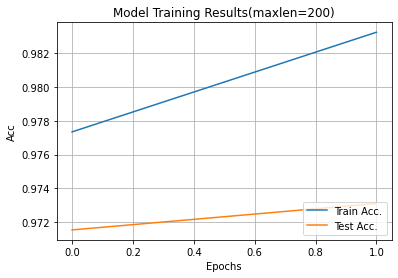

In [33]:
""" Visualize Training Results """
import matplotlib.pyplot as plt
%matplotlib inline
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results(maxlen=200)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()
plt.show()

maxlen = 50
batch_size = 32
epochs = 2
x_train = pad_sequences(tokenized_train, maxlen=maxlen)
x_test = pad_sequences(tokenized_test, maxlen=maxlen)

inp = Input(shape=(maxlen,))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(
    Dropout(0.1)(
        Dense(50, activation="relu")(x)))

model = Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=[x_test,y_test])

""" Visualize Training Results """
import matplotlib.pyplot as plt
%matplotlib inline
### Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

### Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

### Show plot
plt.title('Model Training Results')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()
plt.show()

###@Author Pu Hongxi
<br><br>
# Experiment with other models

## 1.TextCNN
According to the paper Convolutional Neural Networks for Sentence Classification by Yoon Kim, we can use word vector and use CNN as we do to images. The paper says CNN has excellent performance on sentence-level classification tasks with multiple benchmarks. So let's first give it a shoot and we will do some analysis once we have got the result.

In [13]:
#Preprocessing  is the same; Running the following when the padding is finished
import pandas as pd
import numpy as np

from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model
x_train;
y_train;
x_test;
y_test;

In [23]:
#CNN model
#try to choose the same parameter as before so that we can compare the result with regards to the model choice
#Parameters without specific comment are subject to fine-tuning.
# the reason why I set them to numerical value is that I don't want to re-run to load the parameter value specified before
emd_size = 128
filters = 250
kernal_size = 3 # normally is set to 3
hidden_dims = 128
vocab_size = 20000 # =max_features
max_length = 200 # =maxlen
epochs #2 It's better to change it to something larger say at least 5
#but I don't want to waste time waiting so I will leave the training with larger epoch to my parter


#As below is a shallow CNN; Definitely we can try with another deep CNN but it will take some time to fine-tuning as well hence
# I will take care of that if I do have some spare time.
# The reset is just routine with nothing worth mentioning.
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, emd_size, input_length=max_length,))
model_cnn.add(Conv1D(filters, kernal_size, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(hidden_dims,activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(6,activation='sigmoid'))
model_cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_cnn.summary()

#Fit model
history = model_cnn.fit(x_train,y_train, epochs=epochs,validation_data=(x_test,y_test),batch_size=batch_size)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 198, 250)          96250     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 250)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32128     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 2,689,152
Trainable params: 2,689,152
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159571 samples, validate on 63978 samples
Epoch 1/2
159571/159571 [==============================] - 287s 2ms/step - loss: 0.0621 - accuracy: 0.9792 - val_loss: 0.0713 - val_accuracy: 0.9732
Epoch 2/2
159571/159571 [==============================] - 287s 2ms/step - loss: 0.0459 - accuracy: 0.9825 - val_loss: 0.0723 - val_accuracy: 0.9713


In [24]:
loss,accuracy = model_cnn.evaluate(x_train,y_train)
print("EMM! <manual Exclamation> That's the Training accuracy: {:.5f}".format(accuracy))
loss,accuracy = model_cnn.evaluate(x_test,y_test)
print("That's the one: Testing Accuracy: {:.5f}".format(accuracy))

#should I visualize it? No way for such fancy useless things. Do it yourself if you want.  

159571/159571 [==============================] - 27s 169us/step
EMM! <manual Exclamation> That's the Training accuracy: 0.98581
63978/63978 [==============================] - 11s 172us/step
That's the one: Testing Accuracy: 0.97131


159571/159571 [==============================] - 27s 169us/step
EMM! <manual Exclamation> That's the Training accuracy: 0.98581
63978/63978 [==============================] - 11s 172us/step
That's the one: Testing Accuracy: 0.97131

    It has better performance than LSTM along

## 2.CNN + LSTM
We have tried CNN and LSTM above, now let's implement them together to see the result. The motivation is that I want to see how it handles long sequences together with what to keep and what to forget.


In [24]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [25]:
#CNN model
#try to choose the same parameter as before so that we can compare the result with regards to the model choice
#Parameters without specific comment are subject to fine-tuning.
# the reason why I set them to numerical value is that I don't want to re-run to load the parameter value specified before
emd_size = 128
filters = 250
kernal_size = 3 # normally is set to 3
hidden_dims = 128
vocab_size = 20000 # =max_features
max_length = 200 # =maxlen
units=60
epochs #2 It's better to change it to something larger say at least 5
#but I don't want to waste time waiting so I will leave the training with larger epoch to my parter


#As below is a shallow CNN; Definitely we can try with another deep CNN but it will take some time to fine-tuning as well hence
# I will take care of that if I do have some spare time.
# The reset is just routine with nothing worth mentioning.
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(vocab_size, emd_size, input_length=max_length,))
model_cnn_lstm.add(Conv1D(filters, kernal_size, activation='relu'))
model_cnn_lstm.add(MaxPooling1D()) # also try 2D 
model_cnn_lstm.summary()
model_cnn_lstm.add(LSTM(units=units)) #same as the above
model_cnn_lstm.add(Dense(hidden_dims,activation='relu'))
model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(6,activation='sigmoid'))
model_cnn_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_cnn_lstm.summary()

#Fit model
history = model_cnn_lstm.fit(x_train,y_train, epochs=epochs,validation_data=(x_test,y_test),batch_size=batch_size)



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 198, 250)          96250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 250)           0         
Total params: 2,656,250
Trainable params: 2,656,250
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 198, 250)          96250     
______________________

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159571 samples, validate on 63978 samples
Epoch 1/2
159571/159571 [==============================] - 488s 3ms/step - loss: 0.0604 - accuracy: 0.9799 - val_loss: 0.0748 - val_accuracy: 0.9707
Epoch 2/2
159571/159571 [==============================] - 486s 3ms/step - loss: 0.0451 - accuracy: 0.9830 - val_loss: 0.0778 - val_accuracy: 0.9689


In [26]:
loss,accuracy = model_cnn_lstm.evaluate(x_train,y_train)
print("EMM! <manual Exclamation> That's the Training accuracy: {:.5f}".format(accuracy))
loss,accuracy = model_cnn_lstm.evaluate(x_test,y_test)
print("That's the one: Testing Accuracy: {:.5f}".format(accuracy))

159571/159571 [==============================] - 93s 580us/step
EMM! <manual Exclamation> That's the Training accuracy: 0.98529
63978/63978 [==============================] - 38s 591us/step
That's the one: Testing Accuracy: 0.96890


Till now, the test accuracy of various models is
LSTM:  0.96839
CNN:  0.97131
CNN+ LSTM: 0.96890 

IT's improved compared with the original one. 
As for why it's no better than CNN, I will let my parnter to find out by changing some parameters. 

## 3.BiDirectional RNN(LSTM/GRU)

Now we need something that could remember previous information as well as remembering info for a long period of time.
HA! That's the classical BiDirectional RNN.
Here I only implemented it with LSTM, but in practice it could be done with GRU or both interchangably.
I will leave it to my partner to do some test running,

In [34]:
model_BiD = Sequential()
model_BiD.add(Embedding(vocab_size, emd_size, input_length=max_length,))
model_BiD.add(LSTM(units=units,return_sequences = True))
model_BiD.add(GlobalMaxPooling1D())
model_BiD.add(Dense(hidden_dims,activation='relu'))
model_BiD.add(Dropout(0.5))
model_BiD.add(Dense(6,activation='sigmoid'))
model_BiD.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_BiD.summary()

#Fit model
history = model_BiD.fit(x_train,y_train, epochs=epochs,validation_data=(x_test,y_test),batch_size=batch_size)



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               7808      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 774       
Total params: 2,613,942
Trainable params: 2,613,942
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 159571 samples, validate on 63978 samples
Epoch 1/2
159571/159571 [==============================] - 510s 3ms/step - loss: 0.0662 - accuracy: 0.9783 - val_loss: 0.0748 - val_accuracy: 0.9693
Epoch 2/2
159571/159571 [==============================] - 516s 3ms/step - loss: 0.0448 - accuracy: 0.9832 - val_loss: 0.0681 - val_accuracy: 0.9721


In [35]:
loss,accuracy = model_BiD.evaluate(x_train,y_train)
print("Training accuracy: {:.5f}".format(accuracy))
loss,accuracy = model_BiD.evaluate(x_test,y_test)
print("Testing Accuracy: {:.5f}".format(accuracy))

159571/159571 [==============================] - 86s 539us/step
Training accuracy: 0.98512
63978/63978 [==============================] - 35s 553us/step
Testing Accuracy: 0.97213


Till now, the test accuracy of various models is
LSTM:          0.96839
CNN:           0.97131
CNN+ LSTM:     0.96890 
BiDir RNN:     0.97213


## 4.Attention Models
It's not covered in the lecture but since the release of Hierarchical Attention Networks for Document Classification paper written jointly by CMU and Microsoft guys in 2016, it's been quite popular.
But what is the REAL incentive after trying this model?
It's from the REAL TRUMP: "what do you have to lose? I say, take it.", so here I will give it a shoot as the president does to the hydroxychloroquine.

As below is a simple attention model which help us by pay more attention to some word since toxic comments tend to be determined by just one or two toxic words, especially some 4 letter word, u know.

Obviously, attention can be implemented together with models mentioned above, but since I don't have such time, I will leave it to my partner to do some trial.

In [55]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='{}_W'.format(self.name),
                                 shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                     shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [57]:

model_a = Sequential()
model_a.add(Embedding(vocab_size, emd_size, input_length=max_length,))
model_a.add(LSTM(units=units,return_sequences = True))
model_a.add(Attention(200))
model_a.add(GlobalMaxPooling1D())
model_a.add(Dense(hidden_dims,activation='relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(6,activation='sigmoid'))
model_a.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_a.summary()

#Fit model
history = model_a.fit(x_train,y_train, epochs=epochs,validation_data=(x_test,y_test),batch_size=batch_size)




ValueError: Input 0 is incompatible with layer global_max_pooling1d_10: expected ndim=3, found ndim=2

Also you can try different model layers, but to compare the result, I implemented the same layers.
As below is another way to give it a shot, it's said to be 99% accuracy;
https://www.kaggle.com/sanket30/cudnnlstm-lstm-99-accuracy
You can dig in to find out why his model is better.

In [ ]:
loss,accuracy = model_a.evaluate(x_train,y_train)
print("Training accuracy: {:.5f}".format(accuracy))
loss,accuracy = model_a.evaluate(x_test,y_test)
print("Testing Accuracy: {:.5f}".format(accuracy))

## 5.BERT
As mentioned in the comment, "it's not difficult to implement BERT",so BERT is not implemented. In addition, you may not want to download pretrained model which takes a while through streaming.